Link Google Colab to Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
#Download kaggle.json from Kaggle
#Import json into notebook 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khairul5831","key":"65321e551452fcbb2d3691a1183e5406"}'}

In [0]:
#authenticate json content
!cp kaggle.json ~/.kaggle/
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw-r--r-- 1 root root 67 May 24 16:17 kaggle.json
{"username":"khairul5831","key":"65321e551452fcbb2d3691a1183e5406"}

In [0]:
#Install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 5.3MB 8.7MB/s 
     |████████████████████████████████| 102kB 27.9MB/s 
     |████████████████████████████████| 112kB 47.6MB/s 
     |████████████████████████████████| 51kB 20.0MB/s 


Download the dataset to Google Colab

In [0]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 1.48G/1.49G [00:12<00:00, 121MB/s]
100% 1.49G/1.49G [00:12<00:00, 130MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('breast-histopathology-images.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('IDC_regular_ps50_idx5.zip', 'r')
zip_ref.extractall('BreastCancer')
zip_ref.close()

Start Data Exploration

In [0]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


In [0]:
from os import listdir
listdir('/content/BreastCancer')[:10]

['15472',
 '12750',
 '9078',
 '12820',
 '16551',
 '16896',
 '12890',
 '9225',
 '9265',
 '9323']

In [0]:
imagePatches = glob('/content/BreastCancer/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/BreastCancer/15472/0/15472_idx5_x2101_y2151_class0.png
/content/BreastCancer/15472/0/15472_idx5_x3051_y951_class0.png
/content/BreastCancer/15472/0/15472_idx5_x2701_y1401_class0.png
/content/BreastCancer/15472/0/15472_idx5_x651_y401_class0.png
/content/BreastCancer/15472/0/15472_idx5_x951_y1451_class0.png
/content/BreastCancer/15472/0/15472_idx5_x2201_y601_class0.png
/content/BreastCancer/15472/0/15472_idx5_x2101_y901_class0.png
/content/BreastCancer/15472/0/15472_idx5_x2601_y201_class0.png
/content/BreastCancer/15472/0/15472_idx5_x2951_y1651_class0.png
/content/BreastCancer/15472/0/15472_idx5_x1601_y751_class0.png


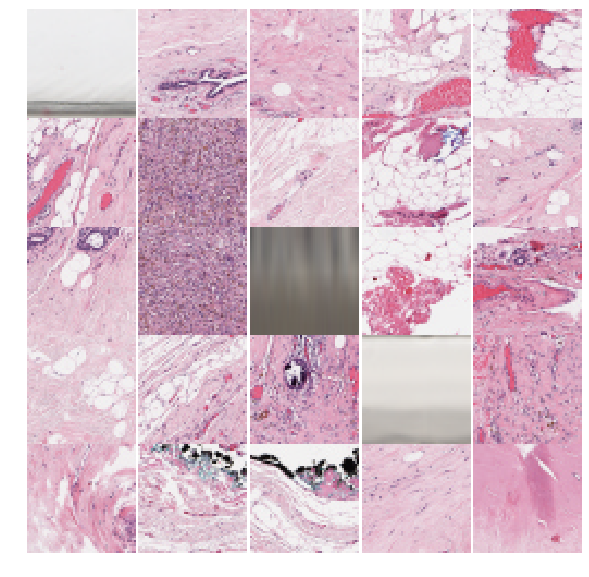

In [0]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [0]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/BreastCancer/15472/0/15472_idx5_x2101_y2151_class0.png', '/content/BreastCancer/15472/0/15472_idx5_x3051_y951_class0.png', '/content/BreastCancer/15472/0/15472_idx5_x2701_y1401_class0.png', '/content/BreastCancer/15472/0/15472_idx5_x651_y401_class0.png', '/content/BreastCancer/15472/0/15472_idx5_x951_y1451_class0.png'] 

IDC(+)

 ['/content/BreastCancer/15472/1/15472_idx5_x1551_y1001_class1.png', '/content/BreastCancer/15472/1/15472_idx5_x1001_y1151_class1.png', '/content/BreastCancer/15472/1/15472_idx5_x1651_y1001_class1.png', '/content/BreastCancer/15472/1/15472_idx5_x1601_y1101_class1.png', '/content/BreastCancer/15472/1/15472_idx5_x1551_y1101_class1.png']


In [0]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

Select 70,000 images

In [0]:
X,Y = proc_images(0,70000)
X1 = np.array(X)
X1.shape

(70000, 50, 50, 3)

In [0]:
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y

In [0]:
X2=df["images"]
Y2=df["labels"]

In [0]:
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] #(0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [0]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 70000
Number of IDC(-) Images: 52750
Number of IDC(+) Images: 17250
Percentage of positive images: 24.64%
Image shape (Width, Height, Channels): (50, 50, 3)


In [0]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[239, 238, 238], [237, 237, 236], [237, 236,...       0
1  [[[217, 208, 233], [212, 206, 229], [219, 206,...       0
2  [[[198, 178, 227], [202, 185, 222], [202, 181,...       0
3  [[[240, 242, 241], [241, 239, 243], [216, 197,...       0
4  [[[228, 215, 233], [234, 228, 236], [239, 237,...       0
5  [[[201, 183, 216], [236, 237, 241], [238, 238,...       0
6  [[[167, 138, 194], [207, 195, 224], [181, 155,...       0
7  [[[227, 219, 231], [210, 195, 229], [226, 216,...       0
8  [[[208, 196, 226], [228, 216, 234], [230, 220,...       0
9  [[[192, 175, 208], [207, 186, 225], [199, 185,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


Start with train and test

In [0]:
X=np.array(X)
X=X/255.0

#split the final dataset into train and test with 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1000)

In [0]:
del X
del X1,X2
del Y2
del imgs0,imgs1
import gc
gc.collect()

39962

In [0]:
X_train.shape

(56000, 50, 50, 3)

In [0]:
X_test.shape

(14000, 50, 50, 3)

In [0]:
#Distribution of Labels
lab = df['labels']
dist = lab.value_counts()
dist

0    52750
1    17250
Name: labels, dtype: int64

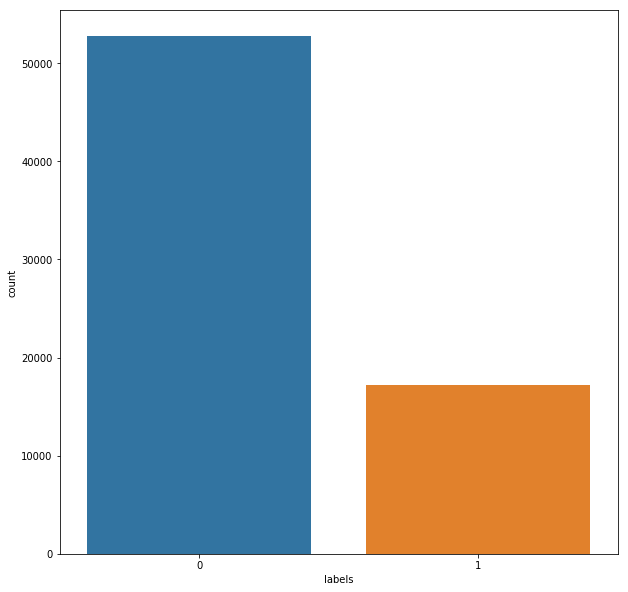

In [0]:
sns.countplot(df['labels'])

-Data is highly imbalanced

In [0]:
# Deal with imbalanced class sizes below
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

{0: 'IDC(-)', 1: 'IDC(+)'}


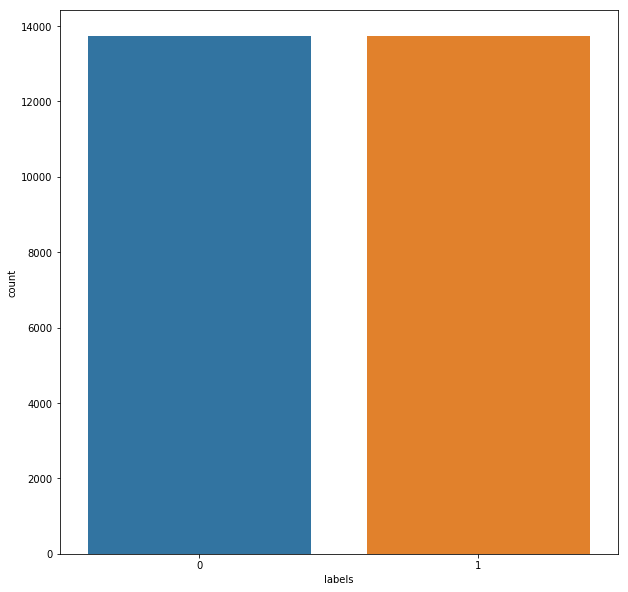

In [0]:
# Encode labels to hot encoder
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(Y_train, num_classes = 2)
y_testHot = to_categorical(Y_test, num_classes = 2)


for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)


for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [0]:
#Distribution value (old) and (new)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [0.66247102 2.03873598]
New Class Weights:  [1. 1.]


Helper Functions

In [0]:
# Helper Functions  

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [0]:
a = X_train
b = y_trainHot
c = X_test
d = y_testHot

num_classes = 2
epochs = 10
img_rows,img_cols=50,50
input_shape = (img_rows, img_cols, 3)
e = 2

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=e))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(datagen.flow(a,b, batch_size=50),
                        steps_per_epoch=len(a) / 32, 
                              epochs=epochs,validation_data = [c, d],
                              callbacks = [MetricsCheckpoint('logs')])

Epoch 1/10
1750/1750 [==============================] - 310s 177ms/step - loss: 0.3842 - acc: 0.8439 - val_loss: 0.3512 - val_acc: 0.8547
Epoch 2/10
1750/1750 [==============================] - 308s 176ms/step - loss: 0.3553 - acc: 0.8586 - val_loss: 0.3242 - val_acc: 0.8739
Epoch 3/10
1750/1750 [==============================] - 307s 175ms/step - loss: 0.3420 - acc: 0.8638 - val_loss: 0.3037 - val_acc: 0.8789
Epoch 4/10
1750/1750 [==============================] - 306s 175ms/step - loss: 0.3294 - acc: 0.8678 - val_loss: 0.3004 - val_acc: 0.8791
Epoch 5/10
1750/1750 [==============================] - 308s 176ms/step - loss: 0.3260 - acc: 0.8695 - val_loss: 0.3002 - val_acc: 0.8814
Epoch 6/10
1750/1750 [==============================] - 306s 175ms/step - loss: 0.3207 - acc: 0.8707 - val_loss: 0.2971 - val_acc: 0.8828
Epoch 7/10
1750/1750 [==============================] - 310s 177ms/step - loss: 0.3173 - acc: 0.8724 - val_loss: 0.2872 - val_acc: 0.8852
Epoch 8/10
1750/1750 [============

In [0]:
results = model.evaluate(c, d)
for i in range(len(model.metrics_names)):
 print(model.metrics_names[i]," : ", results[i])

14000/14000 [==============================] - 12s 841us/step
loss  :  0.2976383547953197
acc  :  0.8804285714285714


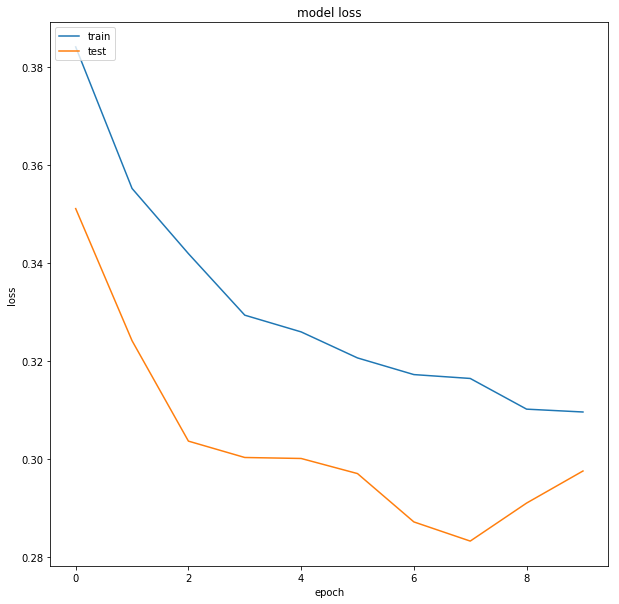

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

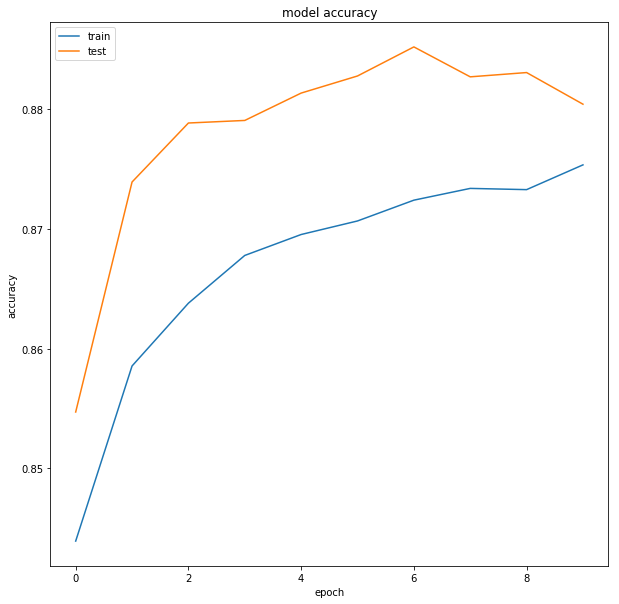

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
y_pred = model.predict(c)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(d,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(c)
print(classification_report(np.argmax(d, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10484
           1       0.75      0.78      0.77      3516

    accuracy                           0.88     14000
   macro avg       0.84      0.85      0.84     14000
weighted avg       0.88      0.88      0.88     14000



- Micro average (averaging the total true positives, false negatives and false positives), 
- Macro average (averaging the unweighted mean per label).
- Weighted average (averaging the support-weighted mean per label)

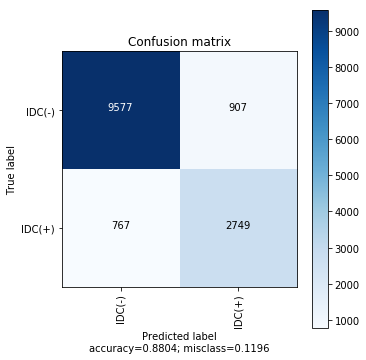

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()